In [1]:
!pip install japanize_matplotlib

In [2]:
from matplotlib import pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from graphviz import Digraph

In [3]:
np.random.seed(0)

In [4]:
# 構造方程式の設定

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def f_X1(sample_size):
    return np.random.binomial(1, 0.5, sample_size)

def f_X2(sample_size):
    return np.random.normal(0, 1, sample_size)

def f_X3(X1, X2, sample_size):
    p = sigmoid(-0.3+0.9*X1-11.2*X2)
    return np.random.binomial(1, p, sample_size)

def f_T(X1, X2, sample_size):
    p = sigmoid(-0.5+1.2*X1+0.8*X2)
    return np.random.binomial(1, p, sample_size)

def f_X4(T, X3, sample_size):
    return 3 + 2.5*T + 3*X3 + np.random.normal(0, np.sqrt(1.5), sample_size)

def f_X5(X4, sample_size):
    return 100 + 10*X4 + np.random.normal(0, np.sqrt(20), sample_size)

def f_Y(X1, X3, X5, sample_size):
    return 1000 + 100*X1 + 500*X3 + 15*X5 + np.random.normal(0, np.sqrt(100), sample_size)

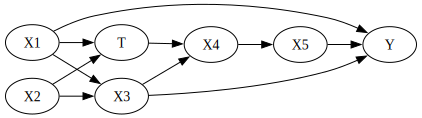

In [5]:
# 因果ダイアグラムの表示
g = Digraph()
g.attr(rankdir='LR')

edges = [
    ('X1', 'X3'), ('X2', 'X3'),
    ('X1', 'T'), ('X2', 'T'),
    ('T', 'X4'), ('X3', 'X4'),
    ('X4', 'X5'),
    ('X1', 'Y'), ('X3', 'Y'), ('X5', 'Y')
]

for src, dst in edges:
    g.edge(src, dst)

g

In [6]:
# データの生成

sample_size = 100
X1 = f_X1(sample_size)
X2 = f_X2(sample_size)
X3 = f_X3(X1, X2, sample_size)
T = f_T(X1, X2, sample_size)
X4 = f_X4(T, X3, sample_size)
X5 = f_X5(X4, sample_size)
Y = f_Y(X1, X3, X5, sample_size)

df = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y
})

In [7]:
# T=0と介入した場合のデータの生成

sample_size = 10000
X1 = f_X1(sample_size)
X2 = f_X2(sample_size)
X3 = f_X3(X1, X2, sample_size)
T = np.zeros(sample_size)
X4 = f_X4(T, X3, sample_size)
X5 = f_X5(X4, sample_size)
Y = f_Y(X1, X3, X5, sample_size)

df_0 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y
})

In [8]:
# T=1と介入した場合のデータの生成

sample_size = 10000
X1 = f_X1(sample_size)
X2 = f_X2(sample_size)
X3 = f_X3(X1, X2, sample_size)
T = np.ones(sample_size)
X4 = f_X4(T, X3, sample_size)
X5 = f_X5(X4, sample_size)
Y = f_Y(X1, X3, X5, sample_size)

df_1 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y
})

In [9]:
# 平均因果効果の計算

print('平均因果効果:', df_1['Y'].mean() - df_0['Y'].mean())

平均因果効果: 373.6709065155528


In [10]:
# 周辺分布・条件付き分布の推定

# p(x1)の推定
p_x1 = df['X1'].mean()

# p(x2)の推定
mu_x2 = df['X2'].mean()
sigma_x2 = df['X2'].std()

# p(x3|x1,x2)の推定
logisitic_model_x3 = LogisticRegression()
logisitic_model_x3.fit(df[['X1', 'X2']].values, df['X3'].values)

# p(t|x1,x2)の推定
logisitic_model_t = LogisticRegression()
logisitic_model_t.fit(df[['X1', 'X2']].values, df['T'].values)

# p(x4|t,x3)の推定
linear_model_x4 = LinearRegression(fit_intercept=True)
linear_model_x4.fit(df[['T', 'X3']].values, df['X4'].values)
sigma_x4 = np.sqrt(((df['X4'].values - linear_model_x4.predict(df[['T', 'X3']].values)) ** 2).mean())

# p(x5|x4)の推定
linear_model_x5 = LinearRegression(fit_intercept=True)
linear_model_x5.fit(df[['X4']].values, df['X5'].values)
sigma_x5 = np.sqrt(((df['X5'].values - linear_model_x5.predict(df[['X4']].values)) ** 2).mean())

# p(y|x1,x3,x5)の推定
linear_model_y = LinearRegression(fit_intercept=True)
linear_model_y.fit(df[['X1', 'X3', 'X5']].values, df['Y'].values)
sigma_y = np.sqrt(((df['Y'].values - linear_model_y.predict(df[['X1', 'X3', 'X5']].values)) ** 2).mean())

In [11]:
# 推定した分布での平均因果効果の計算

X1 = np.random.binomial(1, p_x1, 10000)
X2 = np.random.normal(mu_x2, sigma_x2, 10000)
p_X3 = logisitic_model_x3.predict_proba(np.c_[X1, X2])[:, 1]
X3 = np.random.binomial(1, p_X3, 10000)
T = np.zeros(10000)
X4 = np.random.normal(linear_model_x4.predict(np.c_[T, X3]), sigma_x4, 10000)
X5 = np.random.normal(linear_model_x5.predict(np.c_[X4]), sigma_x5, 10000)
Y_0 = linear_model_y.predict(np.c_[X1, X3, X5])

hat_df_0 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y_0
})

X1 = np.random.binomial(1, p_x1, 10000)
X2 = np.random.normal(mu_x2, sigma_x2, 10000)
p_X3 = logisitic_model_x3.predict_proba(np.c_[X1, X2])[:, 1]
X3 = np.random.binomial(1, p_X3, 10000)
T = np.ones(10000)
X4 = np.random.normal(linear_model_x4.predict(np.c_[T, X3]), sigma_x4, 10000)
X5 = np.random.normal(linear_model_x5.predict(np.c_[X4]), sigma_x5, 10000)
Y_1 = linear_model_y.predict(np.c_[X1, X3, X5])

hat_df_1 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y_1
})

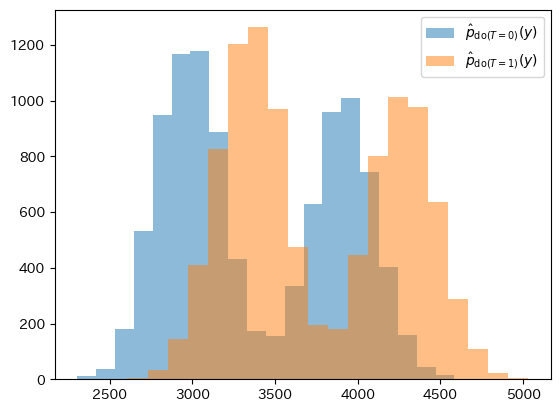

In [12]:
# \hat{p}_{do(T=0)}(y)と\hat{p}_{do(T=1)}(y)の描画

plt.hist(hat_df_0['Y'], bins=20, alpha=0.5, label=r'$\hat{p}_{\mathrm{do}(T=0)}(y)$')
plt.hist(hat_df_1['Y'], bins=20, alpha=0.5, label=r'$\hat{p}_{\mathrm{do}(T=1)}(y)$')
plt.legend()
plt.show();

In [13]:
# 平均因果効果の推定値

print('平均因果効果の推定値:', hat_df_1['Y'].mean() - hat_df_0['Y'].mean())

平均因果効果の推定値: 367.47836906849807


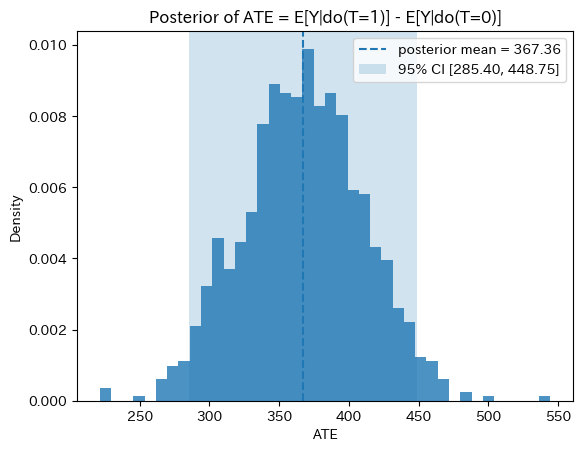

ATE 事後平均: 367.356
ATE 95% 事後信用区間: [285.397, 448.753]


In [18]:
# ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
# ここから：ベイズ推定 + ATE の事後分布推定と可視化
# ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー

from scipy.stats import invgamma, multivariate_normal
import statsmodels.api as sm

rng = np.random.default_rng(42) 

# ===== 1) p(x1) : Bernoulli の Beta 事後 =====
# 事前 Beta(a0, b0)（弱情報）
a0_x1, b0_x1 = 1.0, 1.0
succ = df['X1'].sum()
fail = (len(df) - succ)
a1_x1 = a0_x1 + succ
b1_x1 = b0_x1 + fail
# 以降サンプルは Beta(a1_x1, b1_x1) から

# ===== 2) p(x2) : Normal–Inverse-Gamma 事後 =====
# 事前：mu ~ N(mu0, sigma2/kappa0), sigma2 ~ InvGamma(alpha0, beta0)
mu0_x2, kappa0_x2 = 0.0, 1e-6
alpha0_x2, beta0_x2 = 1e-6, 1e-6
x = df['X2'].values
n = len(x)
xbar = x.mean()
Sxx = ((x - xbar)**2).sum()

kappa1_x2 = kappa0_x2 + n
mu1_x2 = (kappa0_x2*mu0_x2 + n*xbar) / kappa1_x2
alpha1_x2 = alpha0_x2 + n/2
beta1_x2 = beta0_x2 + 0.5 * (Sxx + (kappa0_x2*n/(kappa1_x2))*(xbar - mu0_x2)**2)
# サンプル方法：sigma2 ~ InvGamma(alpha1_x2, beta1_x2), mu ~ N(mu1_x2, sigma2/kappa1_x2)

# ===== 3) p(x3|x1,x2) : ロジスティック回帰（ラプラス近似） =====
X_x3 = sm.add_constant(df[['X1', 'X2']].values)
y_x3 = df['X3'].values
logit_x3 = sm.Logit(y_x3, X_x3).fit(disp=False)
beta_hat_x3 = logit_x3.params              # [intercept, X1, X2]
cov_beta_x3 = logit_x3.cov_params()        # 近似事後：N(beta_hat, cov)

# ===== 4) p(t|x1,x2) : ロジスティック回帰（ラプラス近似） =====
X_t = sm.add_constant(df[['X1', 'X2']].values)
y_t = df['T'].values
logit_t = sm.Logit(y_t, X_t).fit(disp=False)
beta_hat_t = logit_t.params
cov_beta_t = logit_t.cov_params()

# ===== 共役正規線形モデルの事後（N–IG）のヘルパ =====
def posterior_NIG(X, y, mu0, Lambda0, a0, b0):
    """
    y|X, beta, sigma2 ~ N(X beta, sigma2 I)
    beta | sigma2 ~ N(mu0, sigma2 * Lambda0^{-1})  （Lambda0 は事前の precision）
    sigma2 ~ InvGamma(a0, b0)

    戻り値: (mu_n, Lambda_n, a_n, b_n) 事後ハイパー（betaの事後は sigma2 条件付きで N）
    """
    # Precision 行列（対称正定）
    XtX = X.T @ X
    Xty = X.T @ y
    Lambda_n = Lambda0 + XtX
    mu_n = np.linalg.solve(Lambda_n, (Lambda0 @ mu0 + Xty))
    a_n = a0 + X.shape[0] / 2.0
    # b_n = b0 + 0.5 * (y'y + mu0'Lambda0 mu0 - mu_n'Lambda_n mu_n)
    yty = float(y.T @ y)
    mu0_L_mu0 = float(mu0.T @ (Lambda0 @ mu0))
    mu_n_L_mu_n = float(mu_n.T @ (Lambda_n @ mu_n))
    b_n = b0 + 0.5 * (yty + mu0_L_mu0 - mu_n_L_mu_n)
    return mu_n, Lambda_n, a_n, b_n

def sample_from_NIG(mu_n, Lambda_n, a_n, b_n, rng):
    # sigma2 ~ InvGamma(a_n, b_n)
    sigma2 = invgamma.rvs(a=a_n, scale=b_n, random_state=rng)
    # beta ~ N(mu_n, sigma2 * Lambda_n^{-1})
    cov_beta = sigma2 * np.linalg.inv(Lambda_n)
    beta = multivariate_normal.rvs(mean=mu_n, cov=cov_beta, random_state=rng)
    return beta, sigma2

# ===== 5) p(x4|t,x3) : 線形ガウス（共役） =====
X_x4 = sm.add_constant(df[['T', 'X3']].values)
y_x4 = df['X4'].values
p_x4 = X_x4.shape[1]
mu0_x4 = np.zeros(p_x4)
Lambda0_x4 = np.eye(p_x4) * 1e-6     # 弱情報
a0_x4, b0_x4 = 1e-6, 1e-6
mu_n_x4, Lam_n_x4, a_n_x4, b_n_x4 = posterior_NIG(X_x4, y_x4, mu0_x4, Lambda0_x4, a0_x4, b0_x4)

# ===== 6) p(x5|x4) : 線形ガウス（共役） =====
X_x5 = sm.add_constant(df[['X4']].values)
y_x5 = df['X5'].values
p_x5 = X_x5.shape[1]
mu0_x5 = np.zeros(p_x5)
Lambda0_x5 = np.eye(p_x5) * 1e-6
a0_x5, b0_x5 = 1e-6, 1e-6
mu_n_x5, Lam_n_x5, a_n_x5, b_n_x5 = posterior_NIG(X_x5, y_x5, mu0_x5, Lambda0_x5, a0_x5, b0_x5)

# ===== 7) p(y|x1,x3,x5) : 線形ガウス（共役） =====
X_y = sm.add_constant(df[['X1', 'X3', 'X5']].values)
y_vec = df['Y'].values
p_y = X_y.shape[1]
mu0_y = np.zeros(p_y)
Lambda0_y = np.eye(p_y) * 1e-6
a0_y, b0_y = 1e-6, 1e-6
mu_n_y, Lam_n_y, a_n_y, b_n_y = posterior_NIG(X_y, y_vec, mu0_y, Lambda0_y, a0_y, b0_y)

# ===== 8) 事後からパラメータをサンプル → do(T=0/1) 下で反事実生成 → ATE の事後 =====
B = 1000     # 事後サンプル数（増やすとより滑らか）
Nsim = 5000  # 各反事実の人工母集団サイズ

ate_samples = np.empty(B)

for b in range(B):
    # -- p(x1)
    p_x1_sample = rng.beta(a1_x1, b1_x1)

    # -- p(x2)
    sigma2_x2 = invgamma.rvs(a=alpha1_x2, scale=beta1_x2, random_state=rng)
    mu_x2_sample = rng.normal(loc=mu1_x2, scale=np.sqrt(sigma2_x2 / kappa1_x2))

    # -- logistic: p(x3|x1,x2)
    beta_x3_draw = multivariate_normal.rvs(mean=beta_hat_x3, cov=cov_beta_x3, random_state=rng)

    # -- logistic: p(t|x1,x2) ※do演算では使わないが整合のためサンプルしておく（必要なら感度分析に使用）
    beta_t_draw = multivariate_normal.rvs(mean=beta_hat_t, cov=cov_beta_t, random_state=rng)

    # -- linear: p(x4|t,x3)
    beta_x4_draw, sigma2_x4_draw = sample_from_NIG(mu_n_x4, Lam_n_x4, a_n_x4, b_n_x4, rng)

    # -- linear: p(x5|x4)
    beta_x5_draw, sigma2_x5_draw = sample_from_NIG(mu_n_x5, Lam_n_x5, a_n_x5, b_n_x5, rng)

    # -- linear: p(y|x1,x3,x5)
    beta_y_draw,  sigma2_y_draw  = sample_from_NIG(mu_n_y,  Lam_n_y,  a_n_y,  b_n_y,  rng)

    # === 反事実生成: do(T=0) ===
    X1_0 = rng.binomial(1, p_x1_sample, Nsim)
    X2_0 = rng.normal(mu_x2_sample, np.sqrt(sigma2_x2), Nsim)
    X3_p0 = sigmoid(beta_x3_draw[0] + beta_x3_draw[1]*X1_0 + beta_x3_draw[2]*X2_0)
    X3_0 = rng.binomial(1, X3_p0)
    T0 = np.zeros(Nsim)
    X4_mean_0 = beta_x4_draw[0] + beta_x4_draw[1]*T0 + beta_x4_draw[2]*X3_0
    X4_0 = rng.normal(X4_mean_0, np.sqrt(sigma2_x4_draw))
    X5_mean_0 = beta_x5_draw[0] + beta_x5_draw[1]*X4_0
    X5_0 = rng.normal(X5_mean_0, np.sqrt(sigma2_x5_draw))
    Y_mean_0 = beta_y_draw[0] + beta_y_draw[1]*X1_0 + beta_y_draw[2]*X3_0 + beta_y_draw[3]*X5_0
    Y0 = rng.normal(Y_mean_0, np.sqrt(sigma2_y_draw))

    # === 反事実生成: do(T=1) ===
    X1_1 = rng.binomial(1, p_x1_sample, Nsim)
    X2_1 = rng.normal(mu_x2_sample, np.sqrt(sigma2_x2), Nsim)
    X3_p1 = sigmoid(beta_x3_draw[0] + beta_x3_draw[1]*X1_1 + beta_x3_draw[2]*X2_1)
    X3_1 = rng.binomial(1, X3_p1)
    T1 = np.ones(Nsim)
    X4_mean_1 = beta_x4_draw[0] + beta_x4_draw[1]*T1 + beta_x4_draw[2]*X3_1
    X4_1 = rng.normal(X4_mean_1, np.sqrt(sigma2_x4_draw))
    X5_mean_1 = beta_x5_draw[0] + beta_x5_draw[1]*X4_1
    X5_1 = rng.normal(X5_mean_1, np.sqrt(sigma2_x5_draw))
    Y_mean_1 = beta_y_draw[0] + beta_y_draw[1]*X1_1 + beta_y_draw[2]*X3_1 + beta_y_draw[3]*X5_1
    Y1 = rng.normal(Y_mean_1, np.sqrt(sigma2_y_draw))

    ate_samples[b] = Y1.mean() - Y0.mean()

# ===== 9) ATE の事後分布を描画 & 数値要約 =====
ci_low, ci_high = np.percentile(ate_samples, [2.5, 97.5])
ate_mean = ate_samples.mean()

plt.figure()
plt.hist(ate_samples, bins=40, alpha=0.8, density=True)
plt.axvline(ate_mean, linestyle='--', label=f'posterior mean = {ate_mean:.2f}')
plt.axvspan(ci_low, ci_high, alpha=0.2, label=f'95% CI [{ci_low:.2f}, {ci_high:.2f}]')
plt.title('Posterior of ATE = E[Y|do(T=1)] - E[Y|do(T=0)]')
plt.legend()
plt.xlabel('ATE')
plt.ylabel('Density')
plt.show()

print(f'ATE 事後平均: {ate_mean:.3f}')
print(f'ATE 95% 事後信用区間: [{ci_low:.3f}, {ci_high:.3f}]')
# ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー
# ここまで：ベイズ推定 + ATE の事後分布推定と可視化
# ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー


In [14]:
# p(y|t, x1, x2)の推定

linear_model_y_t_x1_x2 = LinearRegression(fit_intercept=True)
linear_model_y_t_x1_x2.fit(df[['T', 'X1', 'X2']].values, df['Y'].values)
sigma_y_t_x1_x2 = np.sqrt(((df['Y'].values - linear_model_y_t_x1_x2.predict(df[['T', 'X1', 'X2']].values)) ** 2).mean())

In [15]:
# 推定した分布での平均因果効果の計算

X1 = np.random.binomial(1, p_x1, 10000)
X2 = np.random.normal(mu_x2, sigma_x2, 10000)
T = np.zeros(10000)
Y_0 = np.random.normal(linear_model_y_t_x1_x2.predict(np.c_[T, X1, X2]), sigma_y_t_x1_x2, 10000)

hat_df_0 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'Y': Y_0
})

X1 = np.random.binomial(1, p_x1, 10000)
X2 = np.random.normal(mu_x2, sigma_x2, 10000)
T = np.ones(10000)
Y_1 = np.random.normal(linear_model_y_t_x1_x2.predict(np.c_[T, X1, X2]), sigma_y_t_x1_x2, 10000)

hat_df_1 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'Y': Y_1
})

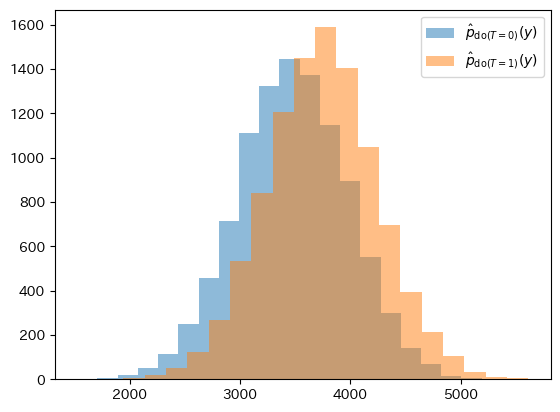

In [15]:
# \hat{p}_{do(T=0)}(y)と\hat{p}_{do(T=1)}(y)の描画

plt.hist(hat_df_0['Y'], bins=20, alpha=0.5, label=r'$\hat{p}_{\mathrm{do}(T=0)}(y)$')
plt.hist(hat_df_1['Y'], bins=20, alpha=0.5, label=r'$\hat{p}_{\mathrm{do}(T=1)}(y)$')
plt.legend()
plt.show();

In [16]:
# 平均因果効果の推定値

print('平均因果効果の推定値:', hat_df_1['Y'].mean() - hat_df_0['Y'].mean())

平均因果効果の推定値: 261.9917017529551


In [17]:
# p(y|t, x1, x3)の推定

linear_model_y_t_x1_x3 = LinearRegression(fit_intercept=True)
linear_model_y_t_x1_x3.fit(df[['T', 'X1', 'X3']].values, df['Y'].values)
sigma_y_t_x1_x3 = np.sqrt(((df['Y'].values - linear_model_y_t_x1_x3.predict(df[['T', 'X1', 'X3']].values)) ** 2).mean())

# p(x1, x3)の推定
p_x1_x3_00 = len(df[(df['X1'] == 0) & (df['X3'] == 0)]) / len(df)
p_x1_x3_01 = len(df[(df['X1'] == 0) & (df['X3'] == 1)]) / len(df)
p_x1_x3_10 = len(df[(df['X1'] == 1) & (df['X3'] == 0)]) / len(df)
p_x1_x3_11 = len(df[(df['X1'] == 1) & (df['X3'] == 1)]) / len(df)

In [18]:
def sample_X1_X3(p_00, p_01, p_10, p_11, size=1):
    """
    与えられた確率 p_00, p_01, p_10, p_11 に従って (X1, X3) をサンプリングし、Pandas DataFrame に格納
    
    :param p_00: P(X1=0, X3=0)
    :param p_01: P(X1=0, X3=1)
    :param p_10: P(X1=1, X3=0)
    :param p_11: P(X1=1, X3=1)
    :param size: 生成するサンプル数
    :return: Pandas DataFrame (カラム名: 'X1', 'X3')
    """
    # 確率分布の累積分布関数 (CDF) を作成
    probs = np.array([p_00, p_01, p_10, p_11])
    cdf = np.cumsum(probs)  # CDFを計算

    # 一様乱数を生成
    U = np.random.rand(size)

    # CDF に基づいて (X1, X3) を選択
    X1 = np.select([U < cdf[0], 
                    (U >= cdf[0]) & (U < cdf[1]), 
                    (U >= cdf[1]) & (U < cdf[2])], 
                   [0, 0, 1], default=1)

    X3 = np.select([U < cdf[0], 
                    (U >= cdf[0]) & (U < cdf[1]), 
                    (U >= cdf[2])], 
                   [0, 1, 1], default=0)
    
    # DataFrame に格納
    df = pd.DataFrame({'X1': X1, 'X3': X3})
    return df


In [19]:
# 推定した分布での平均因果効果の計算

X1X3 = sample_X1_X3(p_x1_x3_00, p_x1_x3_01, p_x1_x3_10, p_x1_x3_11, 10000)
T = np.zeros(10000)
Y_0 = np.random.normal(linear_model_y_t_x1_x3.predict(np.c_[T, X1X3]), sigma_y_t_x1_x3, 10000)

hat_df_0 = pd.DataFrame({
    'X1': X1X3['X1'],
    'X3': X1X3['X3'],
    'T': T,
    'Y': Y_0
})

X1X3 = sample_X1_X3(p_x1_x3_00, p_x1_x3_01, p_x1_x3_10, p_x1_x3_11, 10000)
T = np.ones(10000)
Y_1 = np.random.normal(linear_model_y_t_x1_x3.predict(np.c_[T, X1X3]), sigma_y_t_x1_x3, 10000)

hat_df_1 = pd.DataFrame({
    'X1': X1X3['X1'],
    'X3': X1X3['X3'],
    'T': T,
    'Y': Y_1
})

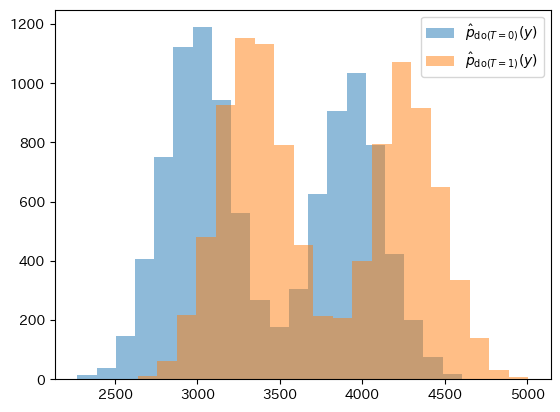

In [20]:
# \hat{p}_{do(T=0)}(y)と\hat{p}_{do(T=1)}(y)の描画

plt.hist(hat_df_0['Y'], bins=20, alpha=0.5, label=r'$\hat{p}_{\mathrm{do}(T=0)}(y)$')
plt.hist(hat_df_1['Y'], bins=20, alpha=0.5, label=r'$\hat{p}_{\mathrm{do}(T=1)}(y)$')
plt.legend()
plt.show();

In [21]:
# 平均因果効果の推定値

print('平均因果効果の推定値:', hat_df_1['Y'].mean() - hat_df_0['Y'].mean())

平均因果効果の推定値: 346.01036831831607
